MMC Direct, a medical motorcycle courier company, delivers important medical items (including lab specimens, medications, and transplant organs) between labs and hospitals throughout the North Carolina Piedmont region.  The company uses motorcycles for efficiency and ease of travel, but this means that couriers can only transport one package at a time. Requests are received from clients at least 24 hours in advance, so demand is known the day before and routes are scheduled at the start of the day.  The company is now exploring automated scheduling and routing to dispatch couriers.  Can an automated system improve MMC's operations? Travel timing is important for sample vitality—minutes matter. 

The following analysis will address the question:

How much could MMC improve efficiency?

###Libraries and Settings

In [616]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [617]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
import datetime

%matplotlib inline

###Functions

In [618]:
# Create df of null_names, null_counts, null_proportion, and null_dtypes
def null_summary(df):
  
    var_null_list = df.columns[df.isna().any()]
    var_null_names = df[var_null_list].dtypes.index
    var_null_counts = df[var_null_list].isna().sum()
    var_null_proportion = df[var_null_list].isna().sum()/df[var_null_list].isna().count()
    var_null_dtypes = df[var_null_list].dtypes
    var_null_df = pd.DataFrame({'null_names' : var_null_names, 'null_counts' : var_null_counts, 'null_proportion' : var_null_proportion, 'null_dtypes' : var_null_dtypes})
  
    return var_null_df.reset_index(drop=True)

In [619]:
# Get distance between two lat/lon coordinates
def dist(lat1, long1, lat2, long2):

    # Convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # Haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in miles is 3958.8
    mi = 3958.8* c
    
    return mi

In [620]:
# Within df columns of lat and lon, find the coordinate that is closest to an input lat/lon coordinate
def find_nearest(dfm, lat, long):

    distances = dfm.apply(lambda row: dist(lat, long, row['base_lat'], row['base_lng']), axis=1)
    
    return dfm.loc[distances.idxmin(), ['base_lat', 'base_lng']]

###EDA

In [621]:
fp = '/content/drive/MyDrive/flyExclusive/'
rqs = pd.read_csv(fp + "requests.csv")
clients = pd.read_csv(fp + "clients.csv")
fleet = pd.read_csv(fp + "fleet.csv")

In [622]:
rqs.sample(6)

,request_id,pickup_client_id,dropoff_client_id,estimated_delivery_mins,expected_dropoff_time,pickup_time,dropoff_time,vehicle_id
29,recJL6tOnsNX9IEQR,2,15,32,2022-06-10T01:40:00-04:00,2022-06-10T01:08:00-04:00,2022-06-10T01:41:00-04:00,20.0
52,recEZ9nQGhpn5oEJo,24,25,25,2022-06-11T09:26:00-04:00,2022-06-11T09:01:00-04:00,2022-06-11T09:31:00-04:00,15.0
120,recBiARsUmdJMcPyh,2,12,43,2022-06-12T04:32:00-04:00,2022-06-12T03:49:00-04:00,2022-06-12T04:29:00-04:00,6.0
132,receOozOiZBlXPmYJ,27,5,55,2022-06-13T09:45:00-04:00,2022-06-13T08:50:00-04:00,2022-06-13T09:48:00-04:00,10.0
104,rec5SXqlQfBa9K7mL,5,19,23,2022-06-12T01:50:00-04:00,2022-06-12T01:27:00-04:00,2022-06-12T01:55:00-04:00,11.0
225,rec8jEUCBRYEpIqwA,31,7,33,2022-06-15T09:52:00-04:00,2022-06-15T09:19:00-04:00,2022-06-15T09:54:00-04:00,19.0


In [623]:
null_summary(rqs)

,null_names,null_counts,null_proportion,null_dtypes
0,dropoff_time,81,0.26129,object
1,vehicle_id,81,0.26129,float64


The null values for dropoff_time and vehicle_id most likely correspond to incomplete/upcoming requests, which are not needed to study route efficiency.

In [624]:
rqs.shape

(310, 8)

In [625]:
rqs = rqs.dropna()
rqs.shape

(229, 8)

In [626]:
clients.head()

,client_name,client_id,lat,lng
0,Duke Health Center South Durham,1,35.911,-78.933
1,Duke University Hospital,2,36.007,-78.938
2,Samaritan Health Center,3,36.013,-78.886
3,Duke Regional Hospital,4,36.037,-78.900
4,Duke Health Center Creekstone,5,35.882,-78.846


In [627]:
null_summary(clients)

,null_names,null_counts,null_proportion,null_dtypes


In [628]:
clients.shape

(33, 4)

In [629]:
fleet.head()

,courier,vehicle_id,base_lat,base_lng,active_tomorrow
0,"Mcclung, Jordyn",1,35.995,-78.902,NaN
1,"Mcclanahan-Saenz, Shanelle",2,35.995,-78.902,NaN
2,"Helton, Greer",3,35.915,-79.053,NaN
3,"Silva Garcia, Domonique",4,35.777,-78.642,NaN
4,"Fahey, Rachel",5,35.995,-78.902,checked


In [630]:
null_summary(fleet)

,null_names,null_counts,null_proportion,null_dtypes
0,active_tomorrow,11,0.55,object


The field, active_tomorrow, will not be used to study efficiency.

In [631]:
fleet.shape

(20, 5)

In [632]:
# Rename columns to distinguish pickup from dropoff.  Merge requests, clients, and fleet data into one df.
clients = clients.rename(columns={'client_id': 'pickup_client_id', 'lat': 'pick_lat', 'lng': 'pick_lng'})
mmc = rqs.merge(clients[['pickup_client_id', 'pick_lat', 'pick_lng']], how='left', on=['pickup_client_id'])
clients = clients.rename(columns={'pickup_client_id': 'dropoff_client_id', 'pick_lat': 'drop_lat', 'pick_lng': 'drop_lng'})
mmc = mmc.merge(clients[['dropoff_client_id', 'drop_lat', 'drop_lng']], how='left', on=['dropoff_client_id'])
mmc = mmc.merge(fleet[['vehicle_id', 'base_lat', 'base_lng']], how='left', on=['vehicle_id'])
mmc.head(3)

,request_id,pickup_client_id,dropoff_client_id,estimated_delivery_mins,expected_dropoff_time,pickup_time,dropoff_time,vehicle_id,pick_lat,pick_lng,drop_lat,drop_lng,base_lat,base_lng
0,recqeDhSbPY0OX0T5,25,20,59,2022-06-10T08:35:00-04:00,2022-06-10T07:36:00-04:00,2022-06-10T08:41:00-04:00,14.0,35.740,-78.781,36.075,-79.271,35.777,-78.642
1,recIuWD6HlVqfL64a,25,2,38,2022-06-10T08:54:00-04:00,2022-06-10T08:16:00-04:00,2022-06-10T08:57:00-04:00,6.0,35.740,-78.781,36.007,-78.938,35.777,-78.642
2,rec2XUPNqoWdFrwgw,6,16,20,2022-06-10T09:01:00-04:00,2022-06-10T08:41:00-04:00,2022-06-10T09:03:00-04:00,18.0,35.969,-78.951,35.913,-79.070,35.995,-78.902


In [633]:
# Break out the dates into a column, which will be used later.
mmc['drop_date'] = pd.to_datetime(mmc['expected_dropoff_time']).dt.date

In [634]:
mmc.groupby('drop_date').apply(lambda group: group.iloc[0])['pickup_time']

drop_date
2022-06-10    2022-06-10T07:36:00-04:00
2022-06-11    2022-06-11T07:23:00-04:00
2022-06-12    2022-06-12T07:19:00-04:00
2022-06-13    2022-06-13T07:47:00-04:00
2022-06-14    2022-06-14T07:30:00-04:00
2022-06-15    2022-06-15T07:31:00-04:00
Name: pickup_time, dtype: object

In [635]:
mmc.groupby('drop_date').apply(lambda group: group.iloc[-1])['expected_dropoff_time']

drop_date
2022-06-10    2022-06-10T05:38:00-04:00
2022-06-11    2022-06-11T05:48:00-04:00
2022-06-12    2022-06-12T05:44:00-04:00
2022-06-13    2022-06-13T05:55:00-04:00
2022-06-14    2022-06-14T05:46:00-04:00
2022-06-15    2022-06-15T12:11:00-04:00
Name: expected_dropoff_time, dtype: object

In [636]:
mmc.groupby('drop_date').apply(lambda group: group.iloc[-2])['expected_dropoff_time']

drop_date
2022-06-10    2022-06-10T05:29:00-04:00
2022-06-11    2022-06-11T05:49:00-04:00
2022-06-12    2022-06-12T05:25:00-04:00
2022-06-13    2022-06-13T05:44:00-04:00
2022-06-14    2022-06-14T05:32:00-04:00
2022-06-15    2022-06-15T11:25:00-04:00
Name: expected_dropoff_time, dtype: object

In [637]:
mmc.groupby('drop_date').apply(lambda group: group.iloc[-1])['dropoff_time']

drop_date
2022-06-10    2022-06-10T05:40:00-04:00
2022-06-11    2022-06-11T05:55:00-04:00
2022-06-12    2022-06-12T05:56:00-04:00
2022-06-13    2022-06-13T05:58:00-04:00
2022-06-14    2022-06-14T05:52:00-04:00
2022-06-15    2022-06-15T12:13:00-04:00
Name: dropoff_time, dtype: object

In [638]:
mmc.groupby('drop_date').apply(lambda group: group.iloc[-2])['dropoff_time']

drop_date
2022-06-10    2022-06-10T05:32:00-04:00
2022-06-11    2022-06-11T05:52:00-04:00
2022-06-12    2022-06-12T05:30:00-04:00
2022-06-13    2022-06-13T05:49:00-04:00
2022-06-14    2022-06-14T05:41:00-04:00
2022-06-15    2022-06-15T11:33:00-04:00
Name: dropoff_time, dtype: object

In general, the time columns appear to be sorted from earliest to latest; however, the data has no indication of AM vs. PM.  The earliest pickups are around 7:00 and the latest dropoffs are before 6:00.  Therefore, the data can be converted to a 24-hr clock without issue, adding 12 hours to the times from 1:00 to 6:00, so that delta times (such as actual_delivery_mins) can be calculated without having negatives.

In [639]:
# Convert time columns to datetimes
mmc['expected_dropoff_time'] = pd.to_datetime(mmc['expected_dropoff_time'])
mmc['pickup_time'] = pd.to_datetime(mmc['pickup_time']) 
mmc['dropoff_time'] = pd.to_datetime(mmc['dropoff_time'])                                                                                  

In [640]:
# Convert to a 24-hr clock by adding 12 hours to the times from 1:00 to 6:00.
mmc.loc[((mmc.expected_dropoff_time.dt.hour >=1) & (mmc.expected_dropoff_time.dt.hour <= 6)), 'expected_dropoff_time'] += pd.Timedelta('12h')
mmc.loc[((mmc.pickup_time.dt.hour >=1) & (mmc.pickup_time.dt.hour <= 6)), 'pickup_time'] += pd.Timedelta('12h')
mmc.loc[((mmc.dropoff_time.dt.hour >=1) & (mmc.dropoff_time.dt.hour <= 6)), 'dropoff_time'] += pd.Timedelta('12h')

In [641]:
# Create a column for actual_delivery_mins
mmc['actual_delivery_mins'] = (mmc['dropoff_time'] - mmc['pickup_time'])/pd.Timedelta('60s')
mmc.insert(1, 'vehicle_id', mmc.pop('vehicle_id'))
mmc.insert(5, 'actual_delivery_mins', mmc.pop('actual_delivery_mins'))
mmc.insert(9, 'base_lat', mmc.pop('base_lat'))
mmc.insert(10, 'base_lng', mmc.pop('base_lng'))
mmc.head(3)

,request_id,vehicle_id,pickup_client_id,dropoff_client_id,estimated_delivery_mins,actual_delivery_mins,expected_dropoff_time,pickup_time,dropoff_time,base_lat,base_lng,pick_lat,pick_lng,drop_lat,drop_lng,drop_date
0,recqeDhSbPY0OX0T5,14.0,25,20,59,65.0,2022-06-10 08:35:00-04:00,2022-06-10 07:36:00-04:00,2022-06-10 08:41:00-04:00,35.777,-78.642,35.740,-78.781,36.075,-79.271,2022-06-10
1,recIuWD6HlVqfL64a,6.0,25,2,38,41.0,2022-06-10 08:54:00-04:00,2022-06-10 08:16:00-04:00,2022-06-10 08:57:00-04:00,35.777,-78.642,35.740,-78.781,36.007,-78.938,2022-06-10
2,rec2XUPNqoWdFrwgw,18.0,6,16,20,22.0,2022-06-10 09:01:00-04:00,2022-06-10 08:41:00-04:00,2022-06-10 09:03:00-04:00,35.995,-78.902,35.969,-78.951,35.913,-79.070,2022-06-10


In [642]:
mmc.estimated_delivery_mins.describe()

count    229.000000
mean      43.903930
std       18.411224
min       16.000000
25%       27.000000
50%       43.000000
75%       57.000000
max       88.000000
Name: estimated_delivery_mins, dtype: float64

In [643]:
mmc.actual_delivery_mins.describe()

count    229.000000
mean      47.253275
std       18.906430
min       13.000000
25%       31.000000
50%       44.000000
75%       62.000000
max       94.000000
Name: actual_delivery_mins, dtype: float64

Next, chain together the legs of each driver's route for each day.  In other words, a driver starts at the base hub in the morning, then after completing a dropoff, the dropoff location becomes the base for the next leg. 

In [644]:
# For each driver's route for each day,
# use the shift function to assign the previous row's dropoff location to the current row's base location.
df_list = []
date_veh = mmc[['drop_date', 'vehicle_id']].drop_duplicates()
for index, row in date_veh.iterrows():
        cond = (mmc.drop_date == row['drop_date']) & (mmc.vehicle_id == row['vehicle_id'])
        df = mmc[cond].reset_index(drop=True)
        df.loc[1:,'base_lat'] = df.loc[:,'drop_lat'].shift(1)
        df.loc[1:,'base_lng'] = df.loc[:,'drop_lng'].shift(1)
        df_list.append(df)
mmc = pd.concat(df_list, ignore_index=True).sort_values(by='pickup_time')

In [645]:
# Compute the total distance of each leg (base -> pickup -> dropoff).
mmc['distance'] = mmc.apply(lambda row: dist(row['base_lat'], row['base_lng'], row['pick_lat'], row['pick_lng']) + 
                                             dist(row['pick_lat'], row['pick_lng'], row['drop_lat'], row['drop_lng']), axis=1)

Check one date-vehicle:

In [646]:
cond = (mmc.drop_date == datetime.date(2022, 6, 10)) & (mmc.vehicle_id == 6.0)
mmc.loc[cond, ['drop_date', 'vehicle_id', 'pickup_time', 'dropoff_time', 'actual_delivery_mins',
               'base_lat', 'base_lng', 'pick_lat', 'pick_lng', 'drop_lat', 'drop_lng', 'distance']]

,drop_date,vehicle_id,pickup_time,dropoff_time,actual_delivery_mins,base_lat,base_lng,pick_lat,pick_lng,drop_lat,drop_lng,distance
5,2022-06-10,6.0,2022-06-10 08:16:00-04:00,2022-06-10 08:57:00-04:00,41.0,35.777,-78.642,35.740,-78.781,36.007,-78.938,28.637398
6,2022-06-10,6.0,2022-06-10 09:31:00-04:00,2022-06-10 10:04:00-04:00,33.0,36.007,-78.938,36.037,-78.900,36.075,-79.271,23.856675
7,2022-06-10,6.0,2022-06-10 10:45:00-04:00,2022-06-10 11:02:00-04:00,17.0,36.075,-79.271,35.911,-78.933,35.834,-78.859,28.775736
8,2022-06-10,6.0,2022-06-10 12:12:00-04:00,2022-06-10 12:32:00-04:00,20.0,35.834,-78.859,35.902,-78.801,36.013,-78.886,14.734815
9,2022-06-10,6.0,2022-06-10 15:32:00-04:00,2022-06-10 16:03:00-04:00,31.0,36.013,-78.886,35.783,-78.581,35.918,-78.825,39.868021


How many requests does each driver complete each day?  Look at the descriptive statistics: 

In [647]:
trips = mmc.groupby(['drop_date', 'vehicle_id'])['request_id'].count()
trips.describe()

count    68.000000
mean      3.367647
std       1.674251
min       1.000000
25%       2.000000
50%       4.000000
75%       5.000000
max       7.000000
Name: request_id, dtype: float64

This will be a parameter in the route optimization.

In [648]:
q25 = trips.quantile(0.25)
q75 = trips.quantile(0.75)
q97 = trips.quantile(0.97)
print('Q25: {}'.format(q25))
print('Q75: {}'.format(q75))
print('Q97: {}'.format(q97))

Q25: 2.0
Q75: 5.0
Q97: 6.0


###Route Optimization

In [649]:
pd.options.mode.chained_assignment = None

search_dist_start = 1   # Search distance from a pickup to find the nearest vehicle
search_dist_inc = 0.5   # Increment to increase search distance
max_req_per_veh_per_day = q97  # A vehicle will be limited to this number of requests per day

clmns = ['request_id', 'drop_date', 'vehicle_id', 'base_lat', 'base_lng',
                      'pick_lat', 'pick_lng', 'drop_lat', 'drop_lng']

# Initialize a df to collect all optimized request legs
optimized_rqs = pd.DataFrame(columns = [x for x in clmns if x not in ['base_lat', 'base_lng']])

# Initialize a list to collect all search distances that were successfully applied
search_dist_list = []

# Loop through the dates
for ii, date in enumerate(mmc.drop_date.unique().tolist()):

    # The day df holding the original request legs
    day_df = mmc.loc[mmc.drop_date == date, clmns].reset_index(drop=True)

    # Initialize a df that will temporarily hold each newly optimized request leg.
    # For the start, merge this df with the fleet df to reset to the original bases.
    new_legs = day_df.loc[:, ~day_df.columns.isin(['base_lat', 'base_lng'])]
    new_legs.loc[:, ~new_legs.columns.isin(['drop_date', 'vehicle_id'])] = np.nan
    new_legs = new_legs.drop_duplicates().sort_values(by='vehicle_id')
    new_legs = new_legs.merge(fleet[['vehicle_id', 'base_lat', 'base_lng']], how='left', on=['vehicle_id'])
    new_legs['counter'] = 0   # This is a counter to keep track of the number of request legs per vehicle per day

    # Initialize a df to collect all optimized request legs for the day.
    # For bookkeeping, the newly optimized request leg will be moved from new_legs to completed_rqs_day,
    # so that the loop operates only on the incomplete requests in new_legs.
    completed_rqs_day = pd.DataFrame(columns = new_legs.columns)

    # The request ids for the day
    requests = day_df['request_id'].unique().tolist()

    search_dist = search_dist_start
    idx = 0

    # Loop through the requests.  When a request is optimized, it will be removed from the list.
    while requests != []:

        # Get one request_id
        rqs_id = requests[idx]

        # Get the pickup and dropoff coordinates of the request
        pick_lat = day_df.loc[(day_df.request_id == rqs_id), 'pick_lat'].values[0]
        pick_lng = day_df.loc[(day_df.request_id == rqs_id), 'pick_lng'].values[0]
        drop_lat = day_df.loc[(day_df.request_id == rqs_id), 'drop_lat'].values[0]
        drop_lng = day_df.loc[(day_df.request_id == rqs_id), 'drop_lng'].values[0]

        # Find the coordinates of the vehicle nearest to the request pickup
        nearest_base = find_nearest(new_legs, pick_lat, pick_lng)
        base_lat, base_lng = nearest_base.tolist()

        # If the distance between the request pickup and the nearest vehicle is less than the search distance
        if dist(base_lat, base_lng, pick_lat, pick_lng) < search_dist:

            search_dist_list.append(search_dist)

            # There could be multiple vehicles at the base.  Just select the first one (.iloc[0])
            base_vehs = new_legs[(new_legs.base_lat == base_lat) & (new_legs.base_lng == base_lng)]
            veh_id = base_vehs.iloc[0]['vehicle_id']
            
            # Populate the row for the optimized request
            cond = (new_legs.vehicle_id == veh_id)        
            new_legs.loc[cond, 'pick_lat'] = pick_lat
            new_legs.loc[cond, 'pick_lng'] = pick_lng
            new_legs.loc[cond, 'drop_lat'] = drop_lat
            new_legs.loc[cond, 'drop_lng'] = drop_lng
            new_legs.loc[cond, 'request_id'] = rqs_id

            # Collect the optimized request in completed_rqs_day
            completed_rqs_day = pd.concat([completed_rqs_day, new_legs.loc[(new_legs.request_id == rqs_id), :]])
            completed_rqs_day = completed_rqs_day.sort_values(by=['vehicle_id', 'counter']).reset_index(drop=True)

            # If the vehicle has not yet reached the max number of requests in the day
            if new_legs.loc[(new_legs.request_id == rqs_id), 'counter'].values[0] < max_req_per_veh_per_day:

                # Create a new row for the vehicle, where base coordinate equals the previous leg's dropoff
                veh_conti = new_legs.loc[(new_legs.request_id == rqs_id), :]
                veh_conti['base_lat'] = drop_lat
                veh_conti['base_lng'] = drop_lng

                # Update the counter for the new row
                veh_conti['counter'] = new_legs.loc[(new_legs.request_id == rqs_id), 'counter'] + 1

                # For the new row, clear out the old request info, getting it ready for a new request
                # and then concat it with new_legs.
                veh_conti[['request_id', 'pick_lat', 'pick_lng', 'drop_lat', 'drop_lng']] = np.nan
                new_legs = pd.concat([new_legs, veh_conti]).sort_values(by=['vehicle_id', 'counter']).reset_index(drop=True)

            # Drop the optimized request leg from new_legs and day_df (it has been collected in completed_rqs_day)
            new_legs = new_legs.drop(new_legs[new_legs.request_id == rqs_id].index)
            day_df = day_df.drop(day_df[day_df.request_id == rqs_id].index)

            # Remove the optimized request id from the requests list
            requests.remove(rqs_id)

            # Reset the search distance for the next request
            search_dist = search_dist_start

        # If the distance between the request pickup and the nearest vehicle is not less than the search distance,
        # try that search distance on the next request pickup
        else:
            idx += 1

        # If none of the request pickups satisfy the search_dist criteria, increase the search distance
        # and start at the first remaining request again
        if idx == len(requests):
            search_dist += search_dist_inc
            idx = 0

    # Add all of the optimized request legs for the day to optimized_rqs
    optimized_rqs = pd.concat([optimized_rqs, completed_rqs_day]).reset_index(drop=True)

pd.options.mode.chained_assignment = 'warn'

search_dist_series = pd.Series(search_dist_list) 

Checks:

Check one date:

In [650]:
optimized_rqs.insert(3, 'base_lat', optimized_rqs.pop('base_lat'))
optimized_rqs.insert(4, 'base_lng', optimized_rqs.pop('base_lng'))
cond = optimized_rqs.drop_date == datetime.date(2022, 6, 10)
optimized_rqs.loc[cond, :]

,request_id,drop_date,vehicle_id,base_lat,base_lng,pick_lat,pick_lng,drop_lat,drop_lng,counter
0,reciSCXuYRLv97yNc,2022-06-10,1.0,35.995,-78.902,36.013,-78.886,35.876,-78.624,0
1,recCo8LBgwBYDmduJ,2022-06-10,1.0,35.876,-78.624,35.861,-78.680,35.882,-78.846,1
2,reckvfITZEwZ7avlT,2022-06-10,1.0,35.882,-78.846,35.834,-78.859,36.075,-79.271,2
3,recJ619manNaY02hx,2022-06-10,6.0,35.777,-78.642,35.767,-78.616,36.331,-78.449,0
4,recIgDOGfayUK4MdN,2022-06-10,6.0,36.331,-78.449,36.331,-78.449,35.908,-78.598,1
5,recFS7iCk1OhX5Gli,2022-06-10,6.0,35.908,-78.598,35.832,-78.681,36.327,-78.593,2
6,recnnUvCcXYBI0QoF,2022-06-10,7.0,35.915,-79.053,35.913,-79.070,36.075,-79.271,0
7,recluwtUqQcYtp2De,2022-06-10,7.0,36.075,-79.271,36.075,-79.271,35.918,-78.825,1
8,rec2rKRxluOCYwPcG,2022-06-10,7.0,35.918,-78.825,35.918,-78.825,36.037,-79.091,2
9,recK4ABKpA5z7ZEJ5,2022-06-10,7.0,36.037,-79.091,36.037,-79.091,35.722,-79.421,3


In [651]:
mmc.shape

(229, 17)

In [652]:
if mmc.shape[0] == optimized_rqs.shape[0] == len(search_dist_list):
    print("All requests have been optimized")
else:
    print("Not all requests have been optimized")

All requests have been optimized


###Results

In [653]:
print("Descriptive statistics of search distance for all requests:")
search_dist_series.describe()

Descriptive statistics of search distance for all requests:


count    229.000000
mean       4.117904
std        5.653293
min        1.000000
25%        1.000000
50%        2.000000
75%        3.500000
max       30.500000
dtype: float64

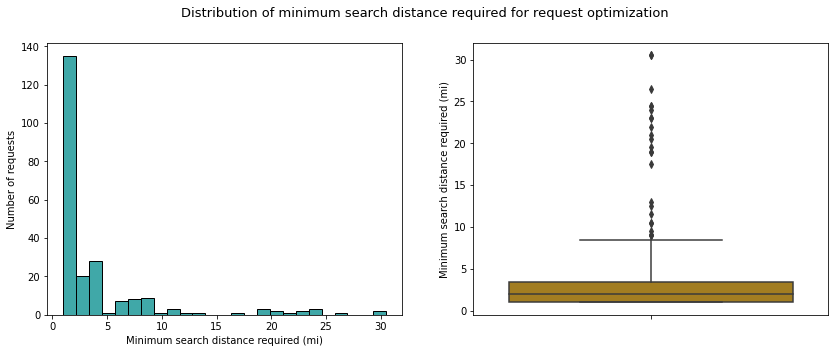

In [654]:
plt.figure(figsize = (14,5))
plt.suptitle("Distribution of minimum search distance required for request optimization", fontsize=13)

plt.subplot(1, 2, 1)
sns.histplot(search_dist_series, bins=25, color='darkcyan')
plt.xlabel("Minimum search distance required (mi)")
plt.ylabel("Number of requests")

plt.subplot(1, 2, 2)
sns.boxplot(y = search_dist_series, whis = 2, color='darkgoldenrod').set(ylabel = "Minimum search distance required (mi)")

plt.show()

For the optimization, most of the requests required a search distance of less than 5 miles.

In [655]:
print("Actual number of vehicles used on each day:")
mmc.groupby(['drop_date'])['vehicle_id'].nunique()

Actual number of vehicles used on each day:


drop_date
2022-06-10    11
2022-06-11    10
2022-06-12    14
2022-06-13    12
2022-06-14    11
2022-06-15    10
Name: vehicle_id, dtype: int64

In [656]:
print("Optimized number of vehicles used on each day:")
optimized_rqs.groupby(['drop_date'])['vehicle_id'].nunique()

Optimized number of vehicles used on each day:


drop_date
2022-06-10    11
2022-06-11    10
2022-06-12    14
2022-06-13     9
2022-06-14    11
2022-06-15     5
Name: vehicle_id, dtype: int64

After the optimization, fewer vehicles are needed on 6-13 and 6-15.

In [657]:
mmc['distance'].describe()

count    229.000000
mean      45.578880
std       18.629606
min       10.975789
25%       30.928721
50%       43.754066
75%       57.986265
max      104.742530
Name: distance, dtype: float64

In [658]:
optimized_rqs['distance'] = optimized_rqs.apply(lambda row: dist(row['base_lat'], row['base_lng'], row['pick_lat'], row['pick_lng']) + 
                                                dist(row['pick_lat'], row['pick_lng'], row['drop_lat'], row['drop_lng']), axis=1)

optimized_rqs['distance'].describe()

count    229.000000
mean      28.729058
std       13.489212
min        7.244683
25%       18.298276
50%       26.291649
75%       38.574772
max       70.593863
Name: distance, dtype: float64

In [659]:
mmc_dist = mmc['distance'].to_frame()
mmc_dist['label'] = 'Actual Distance'
opt_dist = optimized_rqs['distance'].to_frame()
opt_dist['label'] = 'Optimized Distance'
distances = pd.concat([mmc_dist, opt_dist]).reset_index(drop=True)

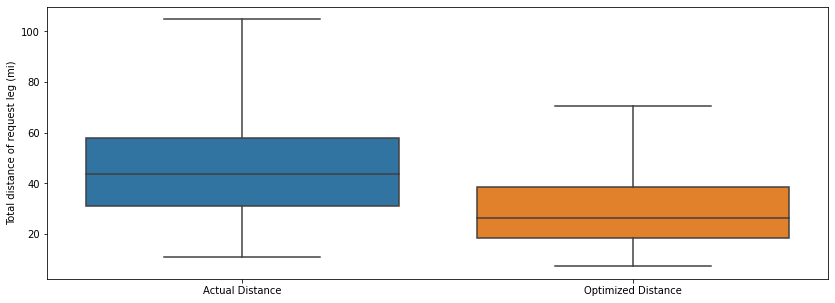

In [660]:
plt.figure(figsize = (14,5))

sns.boxplot(x="label", y="distance", whis=2, data=distances).set(ylabel="Total distance of request leg (mi)", xlabel=None)

plt.show()

The total distance per request leg has greatly improved with the optimization. The median has come down from 44 mi to 26 mi

In [661]:
act_tot_dist = mmc['distance'].sum()
act_tot_time = mmc['actual_delivery_mins'].sum()

opt_tot_dist = optimized_rqs['distance'].sum()
opt_est_tot_time = (opt_tot_dist*(act_tot_time/act_tot_dist))


print("--------Actual--------")
print("Total distance traveled from 2022-06-10 to 2022-06-15:")
print("{} miles".format(act_tot_dist.round(0)))
print("\n")
print("Total minutes of traveling from 2022-06-10 to 2022-06-15:")
print("{} minutes".format(act_tot_time.round(0)))
print("\n"*2)
print("--------Optimized--------")
print("Total distance traveled from 2022-06-10 to 2022-06-15:")
print("{} miles".format(opt_tot_dist.round(0)))
print("\n")
print("ESTIMATED total minutes of traveling from 2022-06-10 to 2022-06-15:")
print("{} minutes".format(opt_est_tot_time.round(0)))
print("\n"*2)
print("Percent drop in total distance traveled:")
print("{} percent".format((100*(act_tot_dist - opt_tot_dist)/act_tot_dist).round(0)))

--------Actual--------
Total distance traveled from 2022-06-10 to 2022-06-15:
10438.0 miles


Total minutes of traveling from 2022-06-10 to 2022-06-15:
10821.0 minutes



--------Optimized--------
Total distance traveled from 2022-06-10 to 2022-06-15:
6579.0 miles


ESTIMATED total minutes of traveling from 2022-06-10 to 2022-06-15:
6821.0 minutes



Percent drop in total distance traveled:
37.0 percent


The optimum total minutes is estimated by multiplying the optimum total distance by the ratio of the actual time to actual distance.  A better time estimate could be obtained after considering the temporal variations, e.g. average leg time per mile in the morning vs. afternoon vs. evening. 